<a href="https://colab.research.google.com/github/thomouvic/txtanalytics/blob/main/doc_sim_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/shera
!cp /content/drive/MyDrive/shera/2022txt.zip .
!unzip -oq 2022txt.zip 

2013txt.zip  2017txt.zip  2021txt.zip		 _digital_humanities_wiki.txt
2014txt.zip  2018txt.zip  2022gephi_0.25sim.csv  docnames.csv
2015txt.zip  2019txt.zip  2022gephi.csv		 docvecs.csv
2016txt.zip  2020txt.zip  2022txt.zip		 pdf


In [3]:
path = '2022txt'

In [4]:
from pathlib import Path

all_txt_files =[]
for file in Path(f"./{path}/").rglob("*.txt"):
  all_txt_files.append(file.parent / file.name)

n_files = len(all_txt_files)
print(n_files)

258


In [5]:
# A pattern I use often is to load the text files into a pandas dataframe. 
# This is way I get consistent docid's of documents by using the dataframe index. 
# Also, we can later add useful columns to the dataframe, such as 'tokens', see later cells.  

import pandas as pd

# Initialize an empty list to store the data
data = []

# Loop through the file names
for filename in all_txt_files:
    # Read the file into a string
    with open(filename, 'r') as f:
        text = f.read()
    
    # Append the string to the list
    data.append( (filename, text) )

# Create a dataframe from the list of strings
docdf = pd.DataFrame(data, columns=['filename', 'text'])
docdf

,filename,text
0,2022txt/244.txt,Investigating two Late Roman slag heaps in the...
1,2022txt/184.txt,6-7 October 2022 \nPhilipps-Universität Marbur...
2,2022txt/278.txt,QuoteKG :\nA Multilingual Knowledge Graph of Q...
3,2022txt/188.txt,"27 December 2022\n \nCarbé, E., Balbo, A., Tom..."
4,2022txt/169.txt,Thu Dau Mot University Journal of Science - Vo...
...,...,...
253,2022txt/207.txt,\ngiada cerri Shaking Heritage\nMuseum Collect...
254,2022txt/223.txt,\n \n \n Hidden Cities \nThis groundbreaking c...
255,2022txt/89.txt,\n 126 \n From A Student Perspective: Video T...
256,2022txt/345.txt,Hannes/uni00A0Werthner\nErich/uni00A0Prem\nEdw...


# TF/IDF

In [6]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

tfidf = TfidfVectorizer(stop_words=stopwords, min_df=2)
dt = tfidf.fit_transform(docdf["text"])
print('Number of bytes', dt.data.nbytes)
dt

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


Number of bytes 6943792
CPU times: user 12.2 s, sys: 1.04 s, total: 13.3 s
Wall time: 16.6 s


<258x111102 sparse matrix of type '<class 'numpy.float64'>'
	with 867974 stored elements in Compressed Sparse Row format>

# Finding the most similar documents

### Timing Cosine Similarity

In [7]:
%%time
from sklearn.metrics.pairwise import cosine_similarity
r = cosine_similarity(dt, dt, dense_output=False)

CPU times: user 351 ms, sys: 9.23 ms, total: 360 ms
Wall time: 417 ms


# Creating the graph dataframe.

In [44]:
# Let's transform the sparse matrix to a pandas dataframe  
import pandas as pd

m = r.tocoo()
tuples = zip(m.row, m.col, m.data)
df = pd.DataFrame(tuples, columns =['docid1', 'docid2', 'score'])
df

# Filtering out duplicates. There are quite a few duplicates in the dataset. 
dup_pairs = df[ (0.99 < df['score']) & (df['docid1']<df['docid2']) ] 
# print( dup_pairs )
dup_list = dup_pairs['docid2'].tolist()
# print(dup_list)
df = df[~df['docid1'].isin(dup_list)]
df = df[~df['docid2'].isin(dup_list)]
# dup_pairs = df[ (0.99 < df['score']) & (df['docid1']<df['docid2']) ]
# print( dup_pairs )

# A: Let's keep only rows with similarity greater than a threshold. 
# A: The threshold is chosen so that we have an average degree of not more than 10.
# A: We set the threshold so that each document has on average about 30 neighbors wrt similarity
# A: Also, let's remove rows with similarity close to 1. These are self-similarities. 
threshold = 0.18
df = df[ threshold <= df['score'] ]
df = df[ 0.99 > df['score'] ]
df.reset_index(drop=True, inplace=True)
df

,docid1,docid2,score
0,1,123,0.350531
1,1,158,0.185236
2,1,127,0.232183
3,1,238,0.187090
4,1,225,0.240378
...,...,...,...
2551,255,189,0.201343
2552,255,206,0.258844
2553,257,76,0.190273
2554,257,80,0.222428


In [45]:
# Let's see the nodes with the most neighbors
print(df.groupby('docid1')['docid2'].count().sort_values(ascending=False).head(50))

docid1
76     107
225    103
69      79
104     76
80      72
115     58
136     55
89      53
156     51
64      47
154     42
87      41
206     38
247     36
122     34
140     31
220     31
17      31
250     30
56      29
215     29
29      29
94      28
252     27
217     26
25      26
71      26
11      26
118     24
189     24
168     24
16      23
219     23
119     22
77      22
161     22
232     22
6       21
169     20
61      20
30      20
75      19
8       18
85      18
141     18
124     17
1       16
9       16
245     16
209     16
Name: docid2, dtype: int64


# Remove nodes with very high degree

They are like stopwords. 
Most probably they are conference proceeding or full books.
They make the graph too dense and convoluted. In the future we should make as unit of analysis pages not full docs. 

In [46]:
# Create a set of values to filter
values_to_remove = {76,225}

# Use boolean indexing to filter the rows
df = df[~df['docid1'].isin(values_to_remove) & ~df['docid2'].isin(values_to_remove)]

print(df.groupby('docid1')['docid2'].count().sort_values(ascending=False).head(50))

docid1
69     77
104    74
80     70
115    56
136    53
89     51
156    49
64     45
154    40
87     39
206    36
247    34
122    32
140    29
17     29
220    29
250    28
56     27
29     27
215    27
94     26
252    25
217    24
71     24
25     24
11     24
118    22
168    22
189    22
16     21
219    21
77     20
119    20
232    20
161    20
6      19
61     19
169    18
30     18
75     17
85     16
8      16
141    16
46     15
209    15
124    15
1      14
245    14
9      14
183    14
Name: docid2, dtype: int64


In [10]:
# https://stackoverflow.com/questions/74175462/attributeerror-module-scipy-sparse-has-no-attribute-coo-array
!pip install 'scipy>=1.8'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.8 MB 251 kB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


In [47]:
import networkx as nx
G = nx.Graph()
G = nx.from_pandas_edgelist(df, 'docid1', 'docid2')

# To visualize the graph use Gephi, or see: https://nightingaledvs.com/how-to-visualize-a-graph-with-a-million-nodes/ 

In [48]:
nx.write_gexf(G, "2022.gexf")

In [52]:
# Exploring some nodes we see interesting from Gephi
print(docdf.iloc[104])

filename                                      2022txt/320.txt
text        NLP4DH 2021\nThe 2nd International Workshop on...
Name: 104, dtype: object


# Modularity community partitioning using NetworkX. 
Either comment out this cell which uses NetworkX or the next which uses Gephi.

Select the nodes of modularity class 0. This is the first class. 
Repeat for modularity class 1, 2, 3, 4.

Then, save as **Gephi** graph for visualization. Use the **modularity** attribute we save here for coloring nodes in Gephi. 

In [50]:
classnum = 0

In [53]:
from networkx.algorithms.community import greedy_modularity_communities

c = greedy_modularity_communities(G,weight='score')
comlist = list(c[classnum])

print(f'Nodes of community {classnum}', comlist)

# Save as gephi graph for visualization
node_to_com = dict()
num_coms = len(c)
for com in range(num_coms):
  if com>4: 
    break; # only consider the top 5 coms, 0,1,2,3,4
  for node in c[com]:
    node_to_com[node] = com

nx.set_node_attributes(G, node_to_com, "modularity")
nx.write_gexf(G, "2022mod.gexf")

Nodes of community 0 [1, 257, 6, 9, 11, 13, 15, 16, 18, 21, 22, 24, 36, 38, 39, 48, 50, 56, 59, 60, 63, 64, 70, 71, 75, 80, 91, 97, 102, 104, 106, 109, 115, 119, 123, 127, 128, 129, 130, 136, 138, 139, 140, 146, 151, 154, 155, 158, 160, 161, 169, 174, 176, 187, 193, 198, 199, 206, 210, 212, 214, 215, 216, 223, 229, 230, 238, 239, 244, 248, 253]


# Get modularity community partitioning using Gephi.
In Gephi go to Data Laboratory and save as csv. 
Now put it somewhere, e.g. /content/drive/MyDrive/shera/2022gephi.csv and read it to a dataframe. 

Select the nodes of modularity class 0. This is the first class. 
Repeat for modularity class 1, 2, 3, 4.

In [16]:
# comdf = pd.read_csv('/content/drive/MyDrive/shera/2022gephi.csv')
# comlist = comdf[ comdf['modularity_class']==classnum ]['Id'].tolist()  
# print(comlist)

# Build wordmap for the selected community. 

In [54]:
# extract rows from docdf with ids in comlist
docdf_com = docdf.iloc[ comlist ]
docdf_com

,filename,text
1,2022txt/184.txt,6-7 October 2022 \nPhilipps-Universität Marbur...
257,2022txt/163.txt,Horizons for sustainability „Constantin Brâncu...
6,2022txt/156.txt,Durham Researc h Online\nDep osited in DR O:\n...
9,2022txt/330.txt,\n \nUniversity of Birmingham\nEditing digita...
11,2022txt/124.txt,\n \n \n Hidden Cities \nThis groundbreaking c...
...,...,...
238,2022txt/202.txt,"\nSebastian M. Herrmann, Katja Kanzler, Stefan..."
239,2022txt/161.txt,"1 \n Amber N. Nickell, Ph.D. \n \nAssistant P..."
244,2022txt/131.txt,0 \n \nInventory of Community-Focused ...
248,2022txt/91.txt,\nFrom \nVernacular to World Heritage\nedited ...


In [55]:
import regex as re
import nltk
from nltk.stem import PorterStemmer

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)


nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords.update(['learners', 'also', 'https'])

def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

def porter_stem(tokens):
  ps = PorterStemmer()
  return [ps.stem(t) for t in tokens]

pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

docdf_com['tokens'] = docdf_com['text'].apply(prepare, pipeline=pipeline)
# keeping only tokens with length >= 4
docdf_com['tokens'] = docdf_com['tokens'].apply(lambda li : [x for x in li if len(x)>=4])
docdf_com

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-55-99ca46edc46d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docdf_com['tokens'] = docdf_com['text'].apply(prepare, pipeline=pipeline)
<ipython-input-55-99ca46edc46d>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docdf_com['tokens'] = docdf_com['tokens'].apply(lambda li : [x for x in li if len(x)>=4])


,filename,text,tokens
1,2022txt/184.txt,6-7 October 2022 \nPhilipps-Universität Marbur...,"[october, philipps-universität, marburg, germa..."
257,2022txt/163.txt,Horizons for sustainability „Constantin Brâncu...,"[horizons, sustainability, constantin, brâncuş..."
6,2022txt/156.txt,Durham Researc h Online\nDep osited in DR O:\n...,"[durham, researc, online, osited, ersion, atta..."
9,2022txt/330.txt,\n \nUniversity of Birmingham\nEditing digita...,"[university, birmingham, editing, digital, kno..."
11,2022txt/124.txt,\n \n \n Hidden Cities \nThis groundbreaking c...,"[hidden, cities, groundbreaking, collection, e..."
...,...,...,...
238,2022txt/202.txt,"\nSebastian M. Herrmann, Katja Kanzler, Stefan...","[sebastian, herrmann, katja, kanzler, stefan, ..."
239,2022txt/161.txt,"1 \n Amber N. Nickell, Ph.D. \n \nAssistant P...","[amber, nickell, assistant, professor, history..."
244,2022txt/131.txt,0 \n \nInventory of Community-Focused ...,"[inventory, community-focused, knowledge, mobi..."
248,2022txt/91.txt,\nFrom \nVernacular to World Heritage\nedited ...,"[vernacular, world, heritage, edited, letizia,..."


In [56]:
# Counting tokens
from collections import Counter

counter = Counter()

# Call counter.update for each row of the column tokens. 
# Counter will be updated each time. 
_ = docdf_com['tokens'].map(counter.update) 
print(counter.most_common(20))

[('digital', 5711), ('research', 4587), ('data', 3436), ('social', 3344), ('university', 2679), ('world', 2419), ('language', 2210), ('cultural', 2182), ('heritage', 2098), ('studies', 2095), ('work', 2094), ('culture', 2028), ('media', 2024), ('different', 1883), ('people', 1831), ('information', 1825), ('analysis', 1813), ('project', 1773), ('students', 1744), ('learning', 1743)]


In [57]:
# transform counter into data frame
min_freq = 2
freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
freq_df = freq_df.query('freq >= @min_freq')
freq_df.index.name = 'token'
freq_df = freq_df.sort_values('freq', ascending=False)
freq_df.head(20)

,freq
token,
digital,5711
research,4587
data,3436
social,3344
university,2679
world,2419
language,2210
cultural,2182
heritage,2098


In [58]:
from wordcloud import WordCloud ###
from collections import Counter ###

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

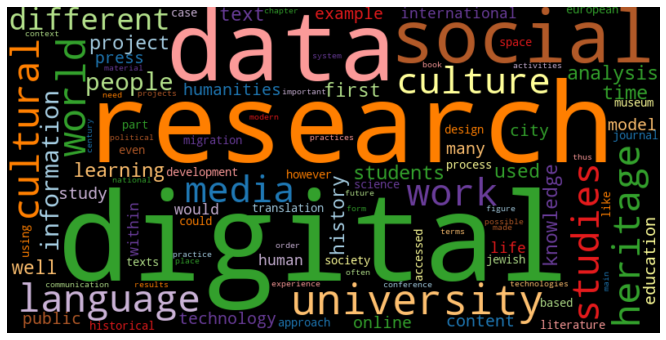

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
wordcloud(freq_df['freq'], max_words=100)    

<ipython-input-60-c92838ac73fd>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1


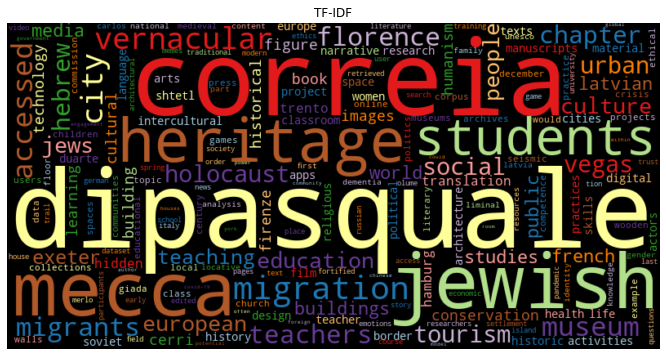

In [60]:
import numpy as np

def compute_idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # count tokens
    counter = Counter()
    df[column].map(update)

    # create data frame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

idf_df = compute_idf(docdf_com)
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

plt.figure(figsize=(12,6)) ###
wordcloud(freq_df['tfidf'], title='TF-IDF', stopwords=['https', 'http'])

**Some conclusions about community 0 using Gephi.** 
These word maps could suggest a community of documents related to law, public policy, and digital tools. For example, document 100 (2022txt/243.txt) is about law practice in Ukraine and includes a considerable number of articles information law in Ukraine. Document 207 (2022txt/178.txt) is about public policy, museum placement, political conflict, and other societal matters. Finally, Robin Wharton is a medievalist, digital humanist, and attorney.   

# TODO
Somehow the topics discovered via wordmaps are too general. How about using the topic discovery chapter in the Blueprints book, and having each page of each document as unit rather than the whole document. The Blueprint chapter suggests paragraphs as units, but it is not easy to extract paragraphs from text extracted from pdf, unless we use a better pdf-to-txt library, such as PDFTRON: https://www.pdftron.com/documentation/python/get-started/python3/windows,

https://www.pdftron.com/documentation/python/get-started/python3/windows/#integrate-into-your-application 

https://www.pdftron.com/documentation/samples/py/TextExtractTest
(Here they extract paragraphs and store them in XML files) 